<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/3_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax


## Set up code

In thiis notebook, we will:

- Implement a fully-vectorized **loss function** for the Softmax classifier.
- Implement the fully-vectorized expression for its **analytic gradient**.
- **Check your implementation** with numerical gradient.
- Use a validation set to **tune the learning rate and regularization** strength.
- **Optimize** the loss function with **SGD**.
- **Visualize** the final learned weights.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# This prints the current working directory.
import os
print('Current working directory: ', os.getcwd())

Current working directory:  /content


In [ ]:
# This should be the location of Lab1 path.
FOLDERPATH = '/content/drive/MyDrive'
assert FOLDERPATH is not None, "[!] Enter the foldername."

# Having downloaded the dataset, let's change to project's directory.
%cd {FOLDERPATH}

/content/drive/MyDrive/labs/lab_1_2024_2025


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules; see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython.
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Pre-processing

In [ ]:
from engine.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = '/content/drive/MyDrive/labs/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue).
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Load .npy files

Load dataset from ``.npy`` files! This way is really faster!

In [ ]:
# Specify project's dir, so that arrays dir is automatically retrieved and arrays can be loaded from it.
labs_dir = '/content/drive/MyDrive/labs'
arrays_dir = os.path.join(labs_dir, 'arrays')

# Load arrays if needed. Uncomment to use!
X_train = np.load(os.path.join(arrays_dir, 'full_X_train.npy'))
y_train = np.load(os.path.join(arrays_dir, 'full_y_train.npy'))
X_test = np.load(os.path.join(arrays_dir, 'full_X_test.npy'))
y_test = np.load(os.path.join(arrays_dir, 'full_y_test.npy'))

# Num of samples for training and test.
num_training = X_train.shape[0]
num_test = X_test.shape[0]

## Split data

In [ ]:
# Split the data into train, val, and test sets. In addition we will create a small development set as a subset of the training data. We can use this for development so our code runs faster.
num_training = 45000
num_validation = 5000
num_test = 10000
num_dev = 500

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,)
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Pre-process data

In [ ]:
# Preprocessing: reshape the image data into rows.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data.
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (45000, 3072)
Validation data shape:  (5000, 3072)
Test data shape:  (10000, 3072)
dev data shape:  (500, 3072)


Some of the elements of the mean image:
[130.81026667 136.10006667 132.57751111 130.21462222 135.4506
 131.84097778 131.12795556 136.25024444 132.56973333 131.65686667]
The mean image of our train set:


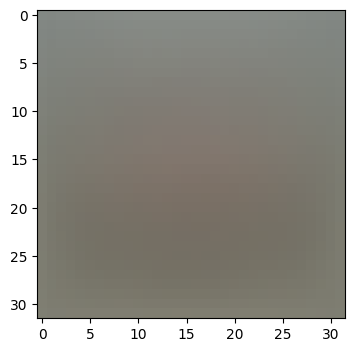

In [ ]:
# Preprocessing: subtract the mean image.

# Compute the image mean based on the training data.
mean_image = np.mean(X_train, axis=0)

# Visualize some of its elements and the image itself.
print('Some of the elements of the mean image:')
print(mean_image[:10]) # Print a few of the elements.
print('The mean image of our train set:')
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # Visualize the mean image.
plt.show()

# Subtract the mean image from train and test data.
mean_image = mean_image.astype('uint8')
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our SVM only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

Let's see our arrays' new shapes after bias trick.

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(45000, 3073) (5000, 3073) (10000, 3073) (500, 3073)


## Softmax Classifier


### Forward and Backward (naive)

We write code for this section in `engine/classifiers/softmax.py` in order to implement the ``softmax_loss_naive()`` function.

In [ ]:
# Implement the naive softmax loss function with nested loops.
from engine.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.332263
sanity check: 2.302585


We expect our loss to be close to -log(0.1). W has been initialized with very small random values, so the initial computation of the loss is based on assigning equal probability(1/10) for each class. Loss is also given by -log(softmax_prob[𝑦]) and that's why we expect a loss close to -log(0.1).



We also implement the gradient in ``softmax_loss_naive()`` function, using a naive way with nested loops.

### Gradient check

In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive) version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool. The numeric gradient should be close to the analytic gradient.
from engine.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Similar to SVM case, do another gradient check with regularization.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.213843 analytic: -0.213843, relative error: 3.514449e-08
numerical: -1.198784 analytic: -1.198784, relative error: 9.047385e-09
numerical: 1.039374 analytic: 1.039373, relative error: 3.295396e-08
numerical: 0.179578 analytic: 0.179577, relative error: 4.509399e-07
numerical: -4.210248 analytic: -4.210248, relative error: 8.372874e-09
numerical: -5.286728 analytic: -5.286728, relative error: 2.448056e-09
numerical: -3.447852 analytic: -3.447852, relative error: 1.720736e-08
numerical: -1.921818 analytic: -1.921818, relative error: 3.053576e-09
numerical: -3.070830 analytic: -3.070830, relative error: 1.633521e-08
numerical: 2.399233 analytic: 2.399233, relative error: 3.265230e-08
numerical: 1.191564 analytic: 1.191564, relative error: 8.200677e-08
numerical: -1.770869 analytic: -1.770869, relative error: 5.176572e-09
numerical: 1.330822 analytic: 1.330822, relative error: 3.132269e-09
numerical: 3.089984 analytic: 3.089984, relative error: 1.211026e-08
numerical: -1.0149

### Forward and Backward (vectorized)

We implement a vectorized version of the softmax loss function in ``softmax_loss_vectorized()`` function of `engine/classifiers/softmax.py`.

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient, we implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from engine.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.332263e+00 computed in 0.082032s
vectorized loss: 2.332263e+00 computed in 0.009399s
Loss difference: 0.000000
Gradient difference: 0.000000


### Hyperparameter search

The code in the below cell chooses the best hyperparameters (regularization strength and
learning rate) by tuning on the validation set (grid search). Our goal is to perform a real-world training in order to save the softmax model that performs the best on validation set.

In [ ]:
from engine.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

# Use the validation set to set the learning rate and regularization strength. This should be identical to the validation that you did for the SVM; save the best trained softmax classifer in best_softmax.

# Provided hyperparameters.
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

results = {}
best_val = -1
best_softmax = None

# Iterate over all combinations of learning rates and regularization strengths.
for lr in learning_rates:
    for reg in regularization_strengths:

        # Create a Softmax classifier and train it.
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)

        # Compute the training and validation accuracy.
        train_accuracy = np.mean(softmax.predict(X_train) == y_train)
        val_accuracy = np.mean(softmax.predict(X_val) == y_val)

        # Store the results for this combination.
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Keep the best validation accuracy and best model.
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 1500: loss 780.002419
iteration 100 / 1500: loss 285.754021
iteration 200 / 1500: loss 105.890128
iteration 300 / 1500: loss 40.112334
iteration 400 / 1500: loss 15.995311
iteration 500 / 1500: loss 7.185380
iteration 600 / 1500: loss 3.976100
iteration 700 / 1500: loss 2.765044
iteration 800 / 1500: loss 2.304313
iteration 900 / 1500: loss 2.145168
iteration 1000 / 1500: loss 2.114422
iteration 1100 / 1500: loss 2.080444
iteration 1200 / 1500: loss 2.098264
iteration 1300 / 1500: loss 2.117525
iteration 1400 / 1500: loss 2.059836
iteration 0 / 1500: loss 1547.478855
iteration 100 / 1500: loss 208.454691
iteration 200 / 1500: loss 29.645801
iteration 300 / 1500: loss 5.766635
iteration 400 / 1500: loss 2.618880
iteration 500 / 1500: loss 2.186626
iteration 600 / 1500: loss 2.126694
iteration 700 / 1500: loss 2.118236
iteration 800 / 1500: loss 2.161203
iteration 900 / 1500: loss 2.127254
iteration 1000 / 1500: loss 2.124365
iteration 1100 / 1500: loss 2.142761
iteration 1

### Predict on test set (unseen images)

Let's see how our model performs on unseen images - the test set.

In [ ]:
# Evaluate the best softmax on test set.
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.332200


Supposing the overall training loss is defined as the sum of the per-datapoint loss over all training examples, it is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss. This is true, because it has to do with the calculation of the loss in the two cases. Loss in SVM takes into account only incorrect classified examples, whereas loss in softmax uses a probability approach for all training examples and, therefor, is affected by every new point(overrall probability distribution). So, if we add a new datapoint to a training set and, if it is correctly classified, the SVVM loss remains unchainged, while the Softmax loss changes.


### Visualization of learned weights for each class

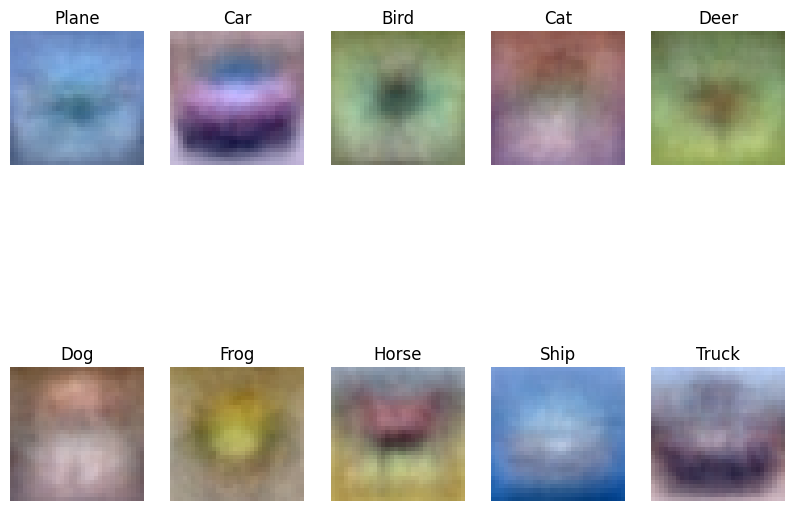

In [ ]:
# Visualize the learned weights for each class.
w = best_softmax.W[:-1,:] # Strip out the bias.
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255.
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

Let's try the classifier on an another dataset.

In the directory ``/content/drive/MyDrive/engine/datasets``, there is a ``get_datasets.sh`` shell script used to download CIFAR-10. We locate the commented-out section within this script that downloads the EuroSAT dataset, which contains satellite images. We use this script to download the EuroSAT dataset.

After downloading, we move the dataset to ``/content/drive/MyDrive/`` directory for conveninence. Next, we locate the ``load_EuroSAT()`` function in the file ``/content/drive/MyDrive/labs/lab_1_2024_2025/engine/data_utils.py``. We use this to load the dataset into the code, following the same approach we used with ``load_CIFAR10()``.

Our goal is to train a Softmax classifier on the EuroSAT dataset. We follow the same steps we used for CIFAR-10 to achieve the highest possible test set accuracy.

## 1. Download and Prepare the EuroSAT dataset.

In [ ]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Current dir.
import os
print('Current working directory: ', os.getcwd())

Current working directory:  /content


In [ ]:
# `FOLDERPATH` variable.
FOLDERPATH = '/content/drive/MyDrive'
assert FOLDERPATH is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that the Python interpreter of the Colab VM can load python files from within it.
import sys
sys.path.insert(1, FOLDERPATH)

In [ ]:
# Download EuroSAT dataset to Drive.
%cd {FOLDERPATH + '/engine/datasets/'}
!bash get_datasets.sh "EuroSAT"

/content/drive/MyDrive/labs/lab_1_2024_2025/engine/datasets


In [ ]:
# Move the dataset to the project's folder after downloading.
import shutil
shutil.move(FOLDERPATH + '/engine/datasets/EuroSAT', '/content/drive/MyDrive')

In [ ]:
# verify the dataset is now in the `labs/` folder
!ls /content/drive/MyDrive

arrays	cifar-10-batches-py  EuroSAT  lab_0_2024_2025  lab_1_2024_2025	lab_2_2024_2025


In [ ]:
# having downloaded the dataset, let's go back to project's folder again.
%cd {FOLDERPATH}

/content/drive/MyDrive/labs/lab_1_2024_2025


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules; see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython.
%load_ext autoreload
%autoreload 2

In [ ]:
from engine.data_utils import load_EuroSAT

# Load the raw EuroSAT data.
eurosat_dir = '/content/drive/MyDrive/EuroSAT'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue).
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_EuroSAT(eurosat_dir)

# Sanity check: we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (24300, 64, 64, 3)
Training labels shape:  (24300,)
Test data shape:  (2700, 64, 64, 3)
Test labels shape:  (2700,)


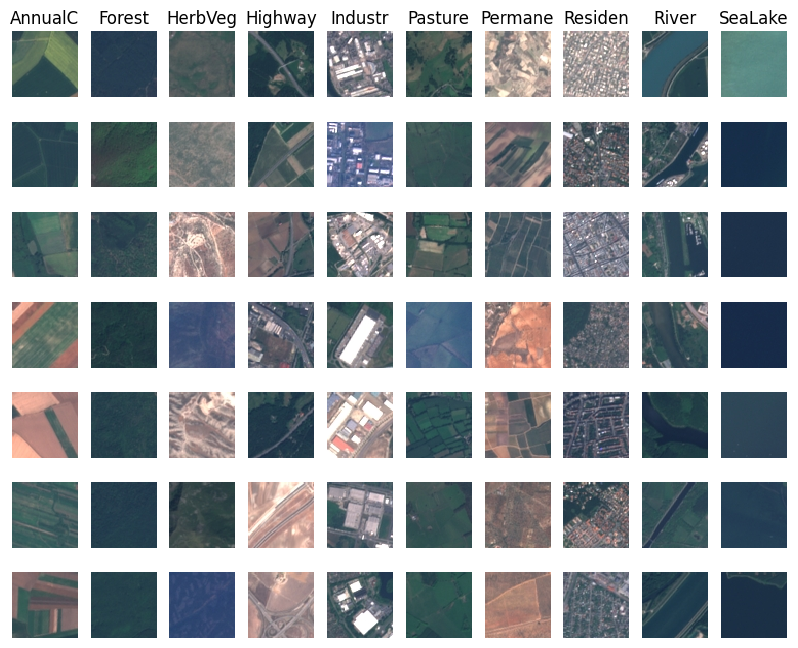

In [ ]:
# Visualize some examples from each class from the dataset.
classes = ['AnnualCrop', 'Forest', 'HerbVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls[:7])
plt.show()

In [ ]:
# Split the data into train, val(10%), and test(10%) sets. In addition we create a small subset of the training data to run faster.
num_training = 21570
num_validation = 2730
num_test = 2700
num_dev = 500

# Validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# The first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (21570, 64, 64, 3)
Train labels shape:  (21570,)
Validation data shape:  (2730, 64, 64, 3)
Validation labels shape:  (2730,)
Test data shape:  (2700, 64, 64, 3)
Test labels shape:  (2700,)


In [ ]:
# Same preprocessing as above.

# 1. Reshape the image data into rows.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# A quick sanity check: print out the shapes of the data.
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

# 2. Compute the image mean based on the training data.
mean_image = np.mean(X_train, axis=0)

# 3. Subtract the mean image from train and test data.
mean_image = mean_image.astype('uint8')
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 4. Append the bias dimension of ones (i.e. bias trick) so that our Softmax classifier has only to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

Training data shape:  (21570, 12288)
Validation data shape:  (2730, 12288)
Test data shape:  (2700, 12288)
dev data shape:  (500, 12288)


In [ ]:
# Check again all shapes.
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(21570, 12289) (2730, 12289) (2700, 12289) (500, 12289)


## 2. Softmax Classifier on EuroSAT dataset.

In [ ]:
# For the same learning rates and regularization strengths as above, we apply the Softmax classifier on a different dataset.
from engine.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

# Set hyperparams.
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# Iterate over all combinations of learning rates and regularization strengths.
for lr in learning_rates:
    for reg in regularization_strengths:

        # Create a Softmax classifier and train it.
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)

        # Compute the training and validation accuracy.
        train_accuracy = np.mean(softmax.predict(X_train) == y_train)
        val_accuracy = np.mean(softmax.predict(X_val) == y_val)

        # Store the results for this combination.
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Keep the best validation accuracy and best model.
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 1500: loss 3101.010608
iteration 100 / 1500: loss 1133.717749
iteration 200 / 1500: loss 417.350948
iteration 300 / 1500: loss 155.850013
iteration 400 / 1500: loss 59.792686
iteration 500 / 1500: loss 25.684703
iteration 600 / 1500: loss 11.763029
iteration 700 / 1500: loss 8.696578
iteration 800 / 1500: loss 6.170870
iteration 900 / 1500: loss 3.855245
iteration 1000 / 1500: loss 3.516259
iteration 1100 / 1500: loss 5.089761
iteration 1200 / 1500: loss 6.289271
iteration 1300 / 1500: loss 4.238880
iteration 1400 / 1500: loss 5.207475
iteration 0 / 1500: loss 6175.251455
iteration 100 / 1500: loss 826.272034
iteration 200 / 1500: loss 114.187368
iteration 300 / 1500: loss 20.973236
iteration 400 / 1500: loss 6.175815
iteration 500 / 1500: loss 5.333603
iteration 600 / 1500: loss 4.894059
iteration 700 / 1500: loss 5.047897
iteration 800 / 1500: loss 3.076920
iteration 900 / 1500: loss 5.759346
iteration 1000 / 1500: loss 3.054564
iteration 1100 / 1500: loss 5.056392
iter

In [ ]:
# Evaluate the best softmax on the test set.
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.178148


This is very poor performance. We will try some different values for learning rate, regularization strengths and also increase the iterations of training to 3000!

In [ ]:
# Some new hyperparrameter values to try.
learning_rates = [1e-9, 1e-8, 1e-7, 5e-7, 1e-5, 1e-2]
regularization_strengths = [1e-3, 1e-4, 1e-5, 1e2, 5e3, 1e4, 5e4]

results = {}
best_val = -1
best_softmax = None

# Iterate over all combinations of learning rates and regularization strengths.
for lr in learning_rates:
    for reg in regularization_strengths:

        # create a Softmax classifier and train it
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=3000, verbose=False)

        # compute the training and validation accuracy
        train_accuracy = np.mean(softmax.predict(X_train) == y_train)
        val_accuracy = np.mean(softmax.predict(X_val) == y_val)

        # store the results for this combination
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # keep the best validation accuracy and best model
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f' % best_val)

/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/softmax.py:107: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(probs[np.arange(num_train), y])
/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/softmax.py:107: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(probs[np.arange(num_train), y])
/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/softmax.py:107: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(probs[np.arange(num_train), y])
/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/softmax.py:107: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(probs[np.arange(num_train), y])
/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/softmax.py:107: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(probs[np.arange(num_train), y])
/content/drive/MyDrive/labs/lab_1_2024_2025/e

lr 1.000000e-09 reg 1.000000e-05 train accuracy: 0.152619 val accuracy: 0.160440
lr 1.000000e-09 reg 1.000000e-04 train accuracy: 0.157441 val accuracy: 0.157875
lr 1.000000e-09 reg 1.000000e-03 train accuracy: 0.163607 val accuracy: 0.143223
lr 1.000000e-09 reg 1.000000e+02 train accuracy: 0.179091 val accuracy: 0.171795
lr 1.000000e-09 reg 5.000000e+03 train accuracy: 0.142652 val accuracy: 0.135897
lr 1.000000e-09 reg 1.000000e+04 train accuracy: 0.157858 val accuracy: 0.156044
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.160593 val accuracy: 0.158242
lr 1.000000e-08 reg 1.000000e-05 train accuracy: 0.205795 val accuracy: 0.209890
lr 1.000000e-08 reg 1.000000e-04 train accuracy: 0.206305 val accuracy: 0.202930
lr 1.000000e-08 reg 1.000000e-03 train accuracy: 0.148030 val accuracy: 0.142491
lr 1.000000e-08 reg 1.000000e+02 train accuracy: 0.200788 val accuracy: 0.185348
lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.217988 val accuracy: 0.208425
lr 1.000000e-08 reg 1.000000

In [ ]:
# Evaluate the best softmax on the test set.
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.248148


This was a 'quick' implementation of experimentation on a very simple Softmax classifier on EuroSAT dataset. We achieved a better accuracy from the previous try, however, for even higher and noticable accuracy we need to try more complex architectures, like CNNs for the given task of image classification.

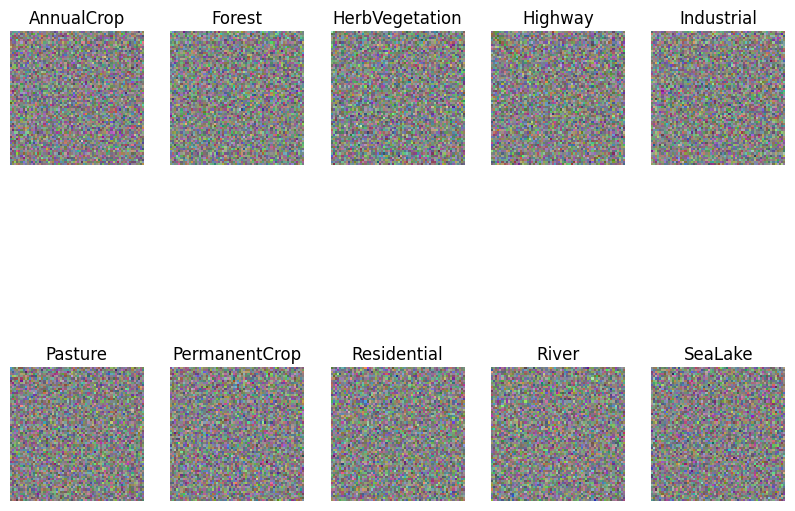

In [ ]:
# Visualize the learned weights for each class.
w = best_softmax.W[:-1,:] # Strip out the bias.
w = w.reshape(64, 64, 3, 10)  # In our case, images shape is (64, 64) in contrast to the cifar's images(32, 32).

w_min, w_max = np.min(w), np.max(w)

classes = ['AnnualCrop', 'Forest', 'HerbVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255.
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In this case, we can't observe anything related to the corresponding classes from best weight vectors for each class. Images come from satelite, contain very colored regions and we need a better way to capture their details(a deep CNN maybe).